<a href="https://colab.research.google.com/github/megakaos/Grupo18/blob/master/Proyecto_Diplomado_Clasificacion_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Diplomado Inteligencia Artificial y Aprendizaje Profundo

**Integrantes**: 

Miguel E Robayo

Diego Mejía LLeras

Edison Vargas Buitrago

# Problema

El ejercicio realizado tiene como objetivo construir una máquina de clasificación de imágenes. Se dispone de un dataset de 59.879 imágenes clasificadas en 12 etiquetas, correspondientes a instancias de distintos tipos de interacción física entre individuos: golpear, correr, inactivo, patear, luchar, agruparse, caminar, abofetear, puñetazo, empujar, "dar los cinco", apalear. La fuente de los datos es: [*CHU SURVEILLANCE VIOLENCE DETECTION DATASET*](https://ieee-dataport.org/documents/chu-surveillance-violence-detection-dataset)

Se probaron dos estrategias de modelación:

1) Red convolucional entrenada totalmente sobre los datos iniciales.

2) Transfer Learning con 2 redes preentrenadas: VGG16 y RESNET.


## Importación de librerias 

Importamos las librerías necesarias

In [1]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow.keras import layers

Mounted at /content/gdrive


# Procesamiento.
Se realiza la canalización de entrada de las imágenes utilizando tf.data. La fuente de referencia es el tutorial de tensorflow [*Cargar Imágenes*](https://www.tensorflow.org/tutorials/load_data/images) 

Probamos si la gpu esta activa

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Rutas de archivo del zip que descargamos anteriormente.

In [3]:
data_dir = '/content/gdrive/MyDrive/Colaboratory/CSVD/rgb'   
data_dir = pathlib.Path(data_dir)

Contamos las imágenes de los archivos disponibles en la ruta preespecificada. El árbol de la ruta es:

"/rgb/nombre_accion/img/archivo.jpg"

In [4]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))    

# primer * Busca en la carpeta "nombre_acción", segundo * busca la carpeta img y el tercer * busca cada imagen que termine con .jpg 

In [5]:
image_count

60176

In [6]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/img/*'), shuffle=False)   
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [7]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/gdrive/MyDrive/Colaboratory/CSVD/rgb/walk/img/walk-0025-frame876.jpg'
b'/content/gdrive/MyDrive/Colaboratory/CSVD/rgb/wave/img/wave-0006-frame148.jpg'
b'/content/gdrive/MyDrive/Colaboratory/CSVD/rgb/wave/img/wave-0002-frame608_oCCbZZ1cLr.jpg'
b'/content/gdrive/MyDrive/Colaboratory/CSVD/rgb/wave/img/wave-0003-frame508_yR5Z5pIBcd.jpg'
b'/content/gdrive/MyDrive/Colaboratory/CSVD/rgb/run/img/run-0002-frame1152.jpg'


Establecemos parámetros de tamáño de la imágen y de batch

In [8]:
batch_size=128
img_height = 128
img_width = 128

Revisamos las clases disponibles

In [9]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "meta.json"]))
print(class_names)

['club' 'grapple' 'highfive' 'idle' 'kick' 'pose' 'punch' 'run' 'shove'
 'slap' 'walk' 'wave']


Construímos las bases de entrenamiento, validación y prueba.

In [10]:
val_size = int(image_count * 0.8)
train_ds = list_ds.skip(val_size)
_ds=list_ds.take(val_size)
val_size = int(len(list(_ds)) * 0.9)
val_ds = _ds.skip(val_size)
test_ds=_ds.take(val_size)

In [11]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())


12036
4814
43326


Función para construir la valiable de labels o etiquetas de los datos

In [12]:
def get_label(file_path):
  # Convierte el path en una lista de componentes de la ruta
  parts = tf.strings.split(file_path, os.path.sep)
  # Construye la clase a partir del nombre del archivo (el nombre de la acción se encuentra en la tercera posición de atrás para delante del texto del nombre del archivo)
  one_hot = parts[-3] == class_names
  # codifica en enteros la etiqueta
  return tf.argmax(one_hot)

Función para transformar cada imágen. La convierte en escala de grises y redimensiona el tamaño de la imágen.

In [13]:
def decode_img(img):
  # Convierte la cadena comprimida de caracteres en un 3Duint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Convierte a blanco y negro para eliminar dos capas (Shape (x,x,1) para que sea más ágil el proceso)
  img = tf.image.rgb_to_grayscale(img)

  # Ajustar el tamaño de la imagen a 128 x 128
  return tf.image.resize(img, [img_height, img_width])

Función que convierte una ruta de archivo en un par (img, label) :

In [14]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Usamos Dataset.map para crear un conjunto de datos de image, label: pares de image, label 

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

In [16]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [17]:
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (128, 128, 1)
Label:  2
Image shape:  (128, 128, 1)
Label:  1
Image shape:  (128, 128, 1)
Label:  11
Image shape:  (128, 128, 1)
Label:  6
Image shape:  (128, 128, 1)
Label:  8


Para entrenar el modelo se sigue la estrategia del tutorial de tensorflow [*Mejor rendimiento con la API tf.data*](https://www.tensorflow.org/guide/data_performance).

La idea es la "captación previa" que superpone al procesamiento previo y la ejecución del modelo. Mientras el modelo ejecuta el paso de entrenamiento s, la canalización de entrada lee los datos del paso s+1 . Al hacerlo, se reduce el tiempo de paso al máximo (en lugar de la suma) del entrenamiento y el tiempo que se tarda en extraer los datos.

La API tf.data proporciona la transformación tf.data.Dataset.prefetch. Se puede utilizar para desacoplar el momento en que se producen los datos del momento en que se consumen los datos. En particular, la transformación utiliza un subproceso en segundo plano y un búfer interno para obtener elementos del conjunto de datos de entrada antes de que se soliciten. El número de elementos para captar previamente debe ser igual (o posiblemente mayor) al número de lotes consumidos por un solo paso de entrenamiento. Se puede ajustar manualmente este valor o establecerlo en tf.data.AUTOTUNE , lo que solicitará al tiempo de ejecución de tf.data que ajuste el valor dinámicamente durante el tiempo de ejecución. Esta función baraja los datos y ejecuta la estrategia recién mencionada.

In [18]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Dibujamos una muestra de imágenes 

In [19]:
"""image_batch, label_batch = next(iter(train_ds))
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  #plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.imshow(image_batch[i].numpy(), cmap='gray', vmin=0, vmax=255)
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")"""

'image_batch, label_batch = next(iter(train_ds))\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(10, 10))\nfor i in range(9):\n  ax = plt.subplot(3, 3, i + 1)\n  #plt.imshow(image_batch[i].numpy().astype("uint8"))\n  plt.imshow(image_batch[i].numpy(), cmap=\'gray\', vmin=0, vmax=255)\n  label = label_batch[i]\n  plt.title(class_names[label])\n  plt.axis("off")'

Se usa la funcionalidad de preprocesamiento de keras para escalar los pixeles y reescalar el tamaño de la imágen.

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_width),
  layers.experimental.preprocessing.Rescaling(1./255)
])

Se usa la funcionalidad de preprocesamiento de keras para hacer "aumentación de datos": rotando las imágenes y desplazándolas

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Red Convolucional
La primera estrategia es plantear un modelo experimental con convoluciones, Maxpooling y Dropout, a entrenar sobre el data set inicial

In [22]:
num_classes = 12

model = tf.keras.Sequential([
  resize_and_rescale,
  #data_augmentation,
  #layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 5, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 7, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(12, activation='softmax')
])

Se compila el modelo. La función de pérdida elegida es la entropía cruzada y la métrica de evaluación la tasa de accuracy

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

Se establecen metaparámetros de épocas y batch

In [24]:
epoch = 50
batchs = 128

Se crea un callback que estpe monitoreando la pérdida y salve el mejor modelo en una ruta interna.

In [25]:
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
filepath = "/content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Se entrena el modelo

In [26]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epoch, batch_size=batchs,  callbacks=callbacks_list)

Epoch 1/50
95/95 [==============================] - 1977s 19s/step - loss: 2.3549 - accuracy: 0.1577 - val_loss: 1.7428 - val_accuracy: 0.3606

Epoch 00001: loss improved from inf to 2.18540, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/assets
Epoch 2/50
95/95 [==============================] - 8s 88ms/step - loss: 1.8226 - accuracy: 0.3505 - val_loss: 1.4734 - val_accuracy: 0.4705

Epoch 00002: loss improved from 2.18540 to 1.71543, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/assets
Epoch 3/50
95/95 [==============================] - 8s 87ms/step - loss: 1.5055 - accuracy: 0.4721 - val_loss: 1.1529 - val_accuracy: 0.5806

Epoch 00003: loss improved from 1.71543 to

Se baja el modelo guardado y se continúa el entrenamiento con los pesos guardados.

In [27]:
# load the model
new_model = load_model(filepath)
#assert_allclose(model.predict(train_ds), new_model.predict(train_ds))

# fit the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history=new_model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=128, callbacks=callbacks_list)

Epoch 1/50
95/95 [==============================] - 9s 92ms/step - loss: 0.2360 - accuracy: 0.9038 - val_loss: 0.2591 - val_accuracy: 0.9146

Epoch 00001: loss improved from inf to 0.23595, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/assets
Epoch 2/50
95/95 [==============================] - 9s 90ms/step - loss: 0.2051 - accuracy: 0.9182 - val_loss: 0.2927 - val_accuracy: 0.9061

Epoch 00002: loss improved from 0.23595 to 0.20513, saving model to /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Diplomado_Inteligencia_Artificial/tmp/assets
Epoch 3/50
95/95 [==============================] - 9s 90ms/step - loss: 0.2121 - accuracy: 0.9160 - val_loss: 0.2671 - val_accuracy: 0.9101

Epoch 00003: loss did not improve from 0.205

In [28]:
new_model.save('/content/gdrive/MyDrive/Colaboratory/my_model.h5')

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)       

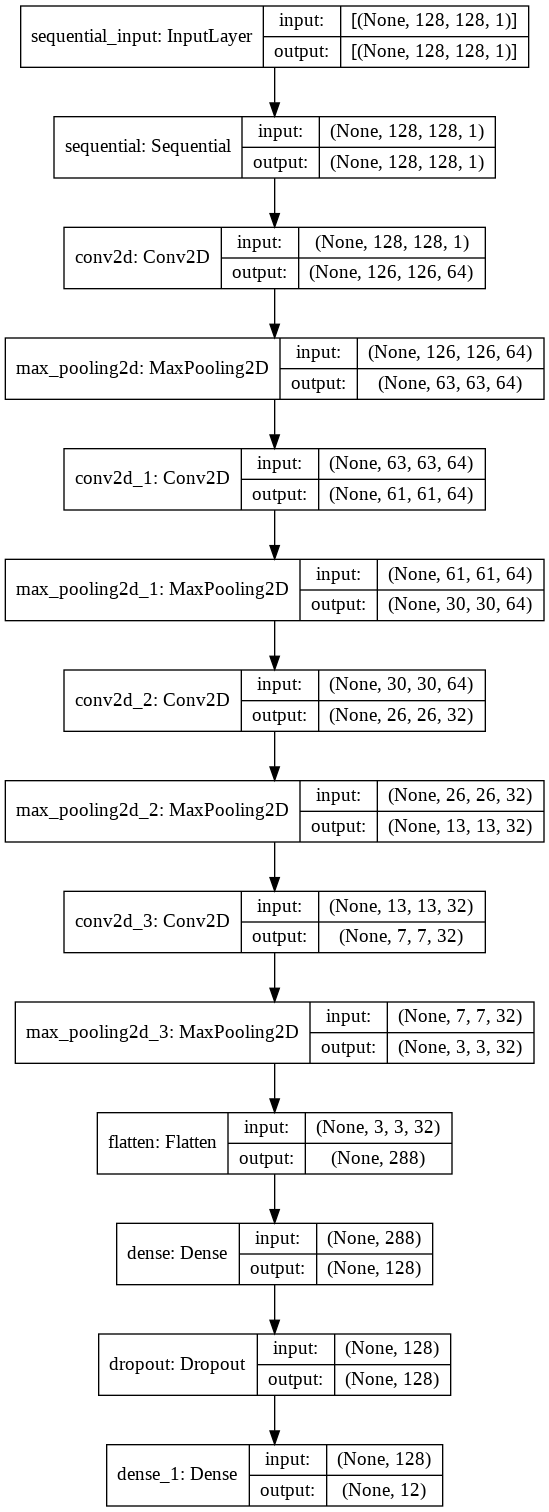

In [36]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='./mnist_dense.png', 
          show_shapes=True, show_dtype=False)

In [39]:
result = model.evaluate(val_ds)

38/38 [==============================] - 1s 31ms/step - loss: 0.2569 - accuracy: 0.9132


In [40]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.25690463185310364
accuracy 0.9131699204444885


Se dibuja la función de pérdida y la métrica de ajuste. Se observa alto desempeño, cierta estabilidad y leve sobreajuste.

In [42]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


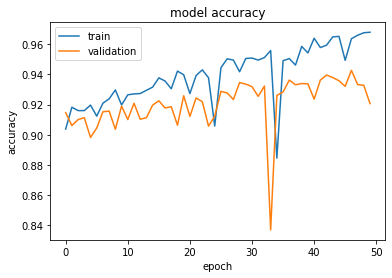

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


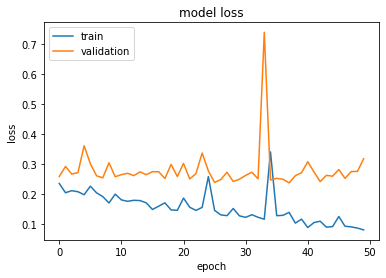

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

# Redes Preentrenadas

La segunda estrategia de modelación es usar transfer learning a partir de modelos preentrenados. Se utilizan 2 modelos del "estado del arte": VGG16 y ResNet. A cada modelo se le ensamblan (en reemplazo del layer final clasificatorio) yna pequeña arquitectura de red que se entrena con los nuevos datos, usando en el proceso los pesos preentrenados de la red original.

## Pre-entrenado ResNet50

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os

In [85]:
val_size2 = int(image_count * 0.8)
train_ds2 = list_ds.skip(val_size2)
_ds2=list_ds.take(val_size2)
val_size2 = int(len(list(_ds2)) * 0.9)
val_ds2 = _ds2.skip(val_size2)
test_ds2=_ds2.take(val_size2)

In [90]:
def get_labelResNet(file_path):
  # Convierte el path en una lista de componentes de la ruta
  parts = tf.strings.split(file_path, os.path.sep)
  # Construye la clase a partir del nombre del archivo (el nombre de la acción se encuentra en la tercera posición de atrás para delante del texto del nombre del archivo)
  one_hot = parts[-3] == class_names
  # codifica en enteros la etiqueta
  return tf.argmax(one_hot)

In [91]:
def decode_imgResNet(img):
  # Convierte la cadena comprimida de caracteres en un 3Duint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)

  # Ajustar el tamaño de la imagen a 128 x 128
  return tf.image.resize(img, [img_height, img_width])

In [92]:
def process_pathResNet(file_path):
  label = get_labelResNet(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_imgResNet(img)
  return img, label

In [93]:
train_ds2 = train_ds2.map(process_pathResNet, num_parallel_calls=AUTOTUNE)
val_ds2 = val_ds2.map(process_pathResNet, num_parallel_calls=AUTOTUNE)

In [94]:
for image, label in train_ds2.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (128, 128, 3)
Label:  2
Image shape:  (128, 128, 3)
Label:  1
Image shape:  (128, 128, 3)
Label:  11
Image shape:  (128, 128, 3)
Label:  6
Image shape:  (128, 128, 3)
Label:  8


In [97]:
def configure_for_performanceResNet(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds2 = configure_for_performanceResNet(train_ds2)
val_ds2 = configure_for_performanceResNet(val_ds2)

In [95]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel =  tf.keras.applications.ResNet50(weights="imagenet", include_top=False,	input_tensor=Input(shape=(128, 128, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
modelResNet = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

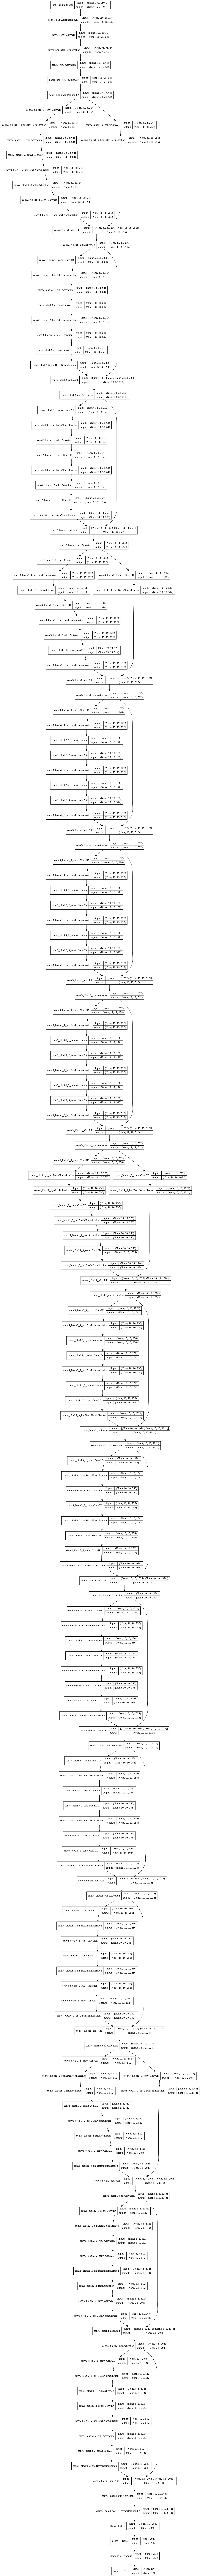

In [48]:
from tensorflow.keras.utils import plot_model

plot_model(modelResNet, to_file='./mnist_dense.png', 
          show_shapes=True, show_dtype=False)

In [107]:
modelResNet.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
"""
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
valAug = ImageDataGenerator()

mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
"""

In [98]:
# Se compila el modelo
print("[INFO] compiling model...")
modelResNet.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

history=modelResNet.fit( train_ds2, validation_data=val_ds2, epochs=epoch, batch_size=batchs)

"""
print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(train_ds, batch_size=32),
	steps_per_epoch=len(train_ds) // 32,
	validation_data=valAug.flow(val_ds),
	validation_steps=len(val_ds) // 32,
	epochs=epochs)
"""

[INFO] compiling model...
Epoch 1/50
95/95 [==============================] - 97s 926ms/step - loss: 2.2880 - accuracy: 0.3739 - val_loss: 0.7625 - val_accuracy: 0.7549
Epoch 2/50
95/95 [==============================] - 17s 175ms/step - loss: 0.9433 - accuracy: 0.6848 - val_loss: 0.4976 - val_accuracy: 0.8432
Epoch 3/50
95/95 [==============================] - 17s 178ms/step - loss: 0.7261 - accuracy: 0.7544 - val_loss: 0.4263 - val_accuracy: 0.8662
Epoch 4/50
95/95 [==============================] - 17s 180ms/step - loss: 0.6064 - accuracy: 0.7957 - val_loss: 0.3661 - val_accuracy: 0.8839
Epoch 5/50
95/95 [==============================] - 17s 181ms/step - loss: 0.5658 - accuracy: 0.8138 - val_loss: 0.3522 - val_accuracy: 0.8812
Epoch 6/50
95/95 [==============================] - 17s 184ms/step - loss: 0.5469 - accuracy: 0.8169 - val_loss: 0.2939 - val_accuracy: 0.8993
Epoch 7/50
95/95 [==============================] - 17s 184ms/step - loss: 0.5269 - accuracy: 0.8198 - val_loss: 0.2

'\nprint("[INFO] training head...")\nH = model.fit(\n\tx=trainAug.flow(train_ds, batch_size=32),\n\tsteps_per_epoch=len(train_ds) // 32,\n\tvalidation_data=valAug.flow(val_ds),\n\tvalidation_steps=len(val_ds) // 32,\n\tepochs=epochs)\n'

In [100]:
modelResNet.save('/content/gdrive/MyDrive/Colaboratory/modelResnet.h5')

Se dibuja la función de pérdida y la métrica de ajuste. Se observa alto desempeño, cierta estabilidad y leve sobreajuste.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


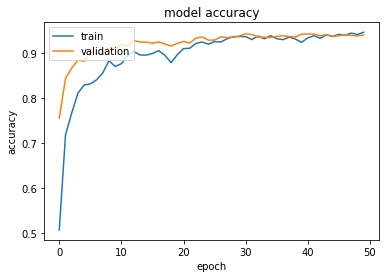

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


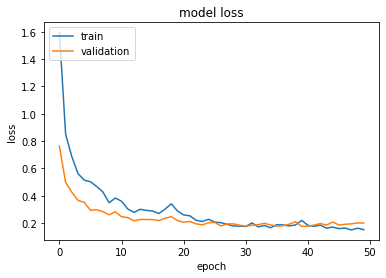

In [101]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

## Preentrenado VGG16

Se repite exáctamente el mismo ejercicio con otra nueva red preentrenada

In [102]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model

In [105]:
baseModel =  VGG16(include_top=False,	input_tensor=Input(shape=(128, 128, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
modelVGG16 = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False

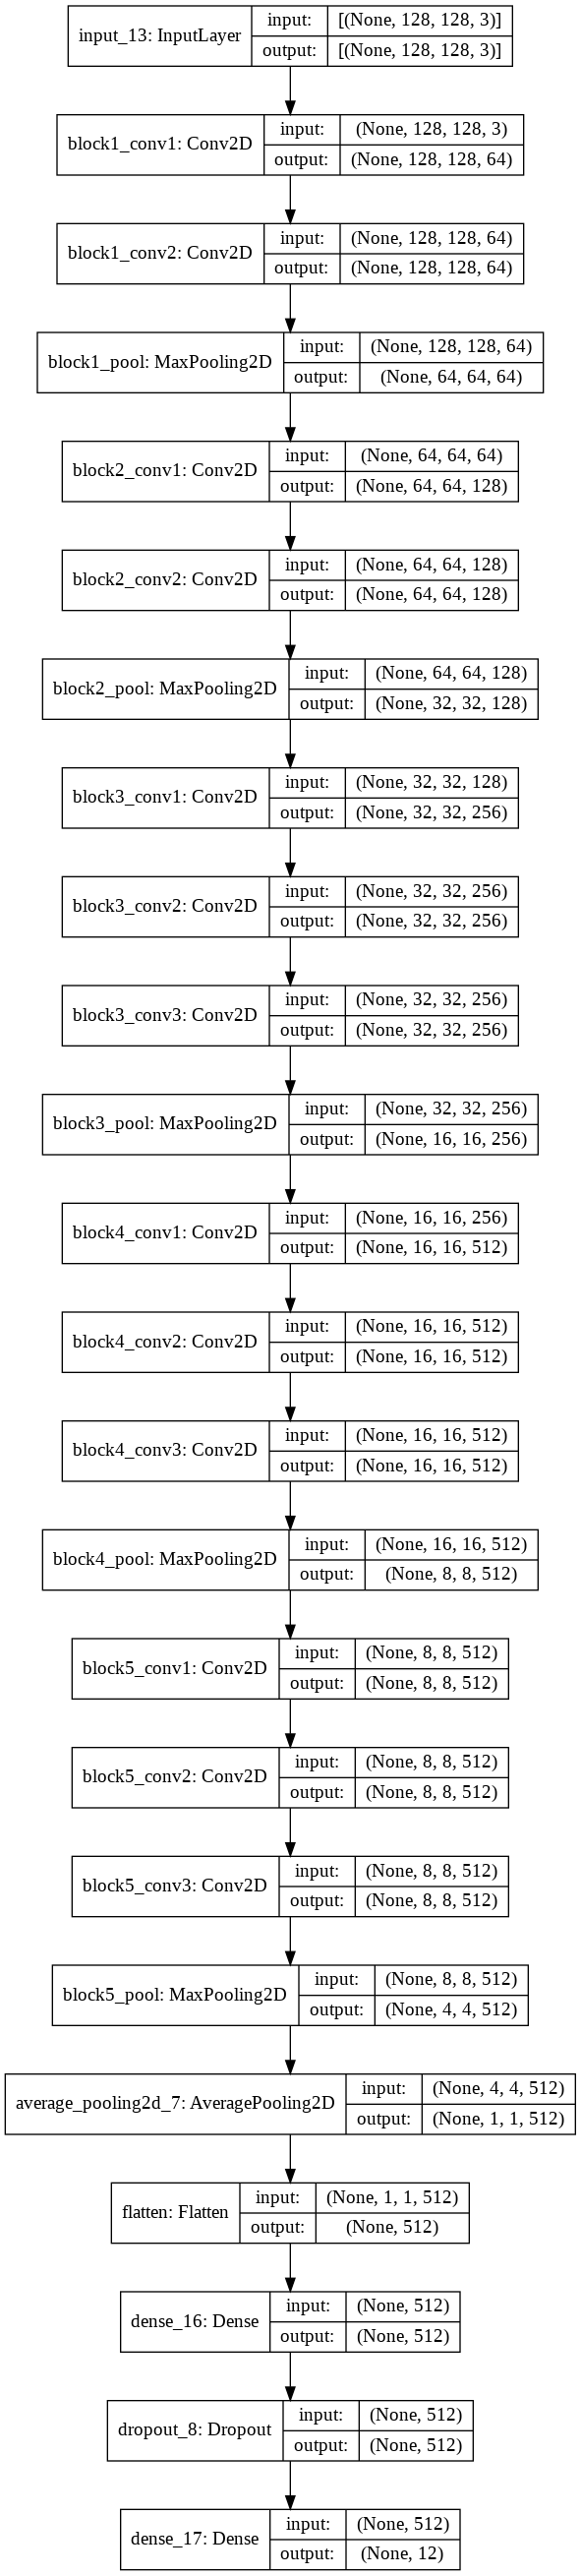

In [106]:
plot_model(modelVGG16, to_file='./mnist_dense.png', 
          show_shapes=True, show_dtype=False)

In [108]:
modelVGG16.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [ ]:
"""
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
"""

In [ ]:
print("[INFO] compiling model...")
modelVGG16.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
history=modelVGG16.fit( train_ds2, validation_data=val_ds2, epochs=epoch, batch_size=batchs)

"""
print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(train_ds, batch_size=32),
	steps_per_epoch=len(train_ds) // 32,
	validation_data=valAug.flow(val_ds),
	validation_steps=len(val_ds) // 32,
	epochs=epochs)
"""

[INFO] compiling model...
Epoch 1/50
95/95 [==============================] - 33s 275ms/step - loss: 5.4635 - accuracy: 0.3838 - val_loss: 0.6895 - val_accuracy: 0.7875
Epoch 2/50
95/95 [==============================] - 21s 218ms/step - loss: 0.8981 - accuracy: 0.7103 - val_loss: 0.4545 - val_accuracy: 0.8525
Epoch 3/50
95/95 [==============================] - 21s 223ms/step - loss: 0.6240 - accuracy: 0.7917 - val_loss: 0.3623 - val_accuracy: 0.8860
Epoch 4/50
95/95 [==============================] - 21s 227ms/step - loss: 0.4779 - accuracy: 0.8425 - val_loss: 0.2824 - val_accuracy: 0.9059
Epoch 5/50
95/95 [==============================] - 21s 227ms/step - loss: 0.4278 - accuracy: 0.8587 - val_loss: 0.2659 - val_accuracy: 0.9121
Epoch 6/50
95/95 [==============================] - 22s 230ms/step - loss: 0.3260 - accuracy: 0.8883 - val_loss: 0.2303 - val_accuracy: 0.9227
Epoch 7/50
95/95 [==============================] - 22s 232ms/step - loss: 0.2858 - accuracy: 0.9042 - val_loss: 0.2

In [ ]:
modelVGG16.save('/content/gdrive/MyDrive/Colaboratory/modelVGG16.h5')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

# Conclusión:

